In [79]:
from datetime import date
from pprint import pprint
from typing import TypedDict
import json
import os

from bs4 import BeautifulSoup
from dotenv import find_dotenv, load_dotenv
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from tqdm.auto import tqdm
from google.api_core import retry
import google.generativeai as genai
import matplotlib.pyplot as plt
import numpy as np
import requests
import pandas as pd
import seaborn as sns

In [3]:
load_dotenv(find_dotenv())
genai.configure(api_key=os.getenv("GEMINI_API_KEY"))

In [94]:
def search_semantic_scholar(query: str, year: tuple[int, int]) -> dict[str, dict[str, str | None]]:
    response = requests.get(
        url="https://api.semanticscholar.org/graph/v1/paper/search",
        params={
            "query": query,
            "fieldsOfStudy": "Computer Science",
            "fields": "paperId,title,abstract,tldr,openAccessPdf",
            "openAccessPdf": "",
            "year": f"{year[0]}-{year[1]}",
            "limit": 15,
        },
    )

    if not response.ok:
        raise Exception(response.text)
    
    return {
        paper["paperId"]: {
            "title": paper["title"],
            "abstract": paper["abstract"],  # may be None
            "pdf_url": paper["openAccessPdf"]["url"],
            "summary": paper["tldr"]["text"],
        }
        for paper in response.json()
    }

In [4]:
system_instruction = """
You are a Computer Science PhD student. Your goal is to write review/survey papers in specific areas of Computer Science. You should be able to:
- Identify research problems and break them down into sub problems
- Conduct thorough literature review on your topic, summarize key findings and identify gaps in existing methodologies
- Formulate clear and testable hypotheses to address your research questions
- Develop experimental methodologies to test your hypotheses, considering factors such as data collection, analysis, and evaluation
- Collect, clean and analyze relevant data using appropriate tools and techniques
- Draw meaningful conclusions from your research findings and discuss their implications
- Prepare high-quality research papers that effectively communicate your findings
"""
model = genai.GenerativeModel(model_name="gemini-1.5-flash", system_instruction=system_instruction)

In [5]:
topic = "Image Classification"

ss_prompt = f"""
You are researching the below topic and need to write a survey paper on the same. Your current goal is only to research on the topic 
and not write anything currently.

Topic: {topic}

Determine an appropriate search query to be used on Semantic Scholar for this topic. Return only the query string and nothing else. 
The output will be used verbatim so make sure that no other data is provided.
"""

response = model.generate_content(ss_prompt)

print(response.text)

"image classification" 



In [ ]:
year = date.today().year
papers = search_semantic_scholar(response.text, (year - 10, year))
pprint(papers)

In [66]:
papers = {
    "f55c3d53eaacc75f497a55ab349276b18ea98cc1": {
        "title": "Fused Node-Level Residual Structure Edge Graph Neural Network for Few-Shot Image Classification",
        "abstract": "In spite of recent rapid developments across various computer vision domains, numerous cutting-edge deep learning algorithms often demand a substantial volume of data to operate effectively. Within this research, a novel few-shot learning approach is presented with the objective of enhancing the accuracy of few-shot image classification. This task entails the classification of unlabeled query samples based on a limited set of labeled support examples. Specifically, the integration of the edge-conditioned graph neural network (EGNN) framework with hierarchical node residual connections is proposed. The primary aim is to enhance the performance of graph neural networks when applied to few-shot classification, a rather unconventional application of hierarchical node residual structures in few-shot image classification tasks. It is noteworthy that this work represents an innovative attempt to combine these two techniques. Extensive experimental findings on publicly available datasets demonstrate that the methodology surpasses the original EGNN algorithm, achieving a maximum improvement of 2.7%. Particularly significant is the performance gain observed on our custom-built dataset, CBAC (Car Brand Appearance Classification), which consistently outperforms the original method, reaching an impressive peak improvement of 11.14%.",
        "pdf_url": "https://www.mdpi.com/2076-3417/13/19/10996/pdf?version=1696651596",
        "summary": "A novel few-shot learning approach is presented with the objective of enhancing the accuracy of few- shot image classification, and the integration of the edge-conditioned graph neural network (EGNN) framework with hierarchical node residual connections is proposed.",
    },
    "969616fc1b82807ee7fb0f7f03f60972e8e6f6c3": {
        "title": "RS Invariant Image Classification and Retrieval with Pretrained Deep Learning Models",
        "abstract": "—CBIR deals with seeking of related images from large dataset, like Internet is a demanding task. Since last two decades scientists are working in this area in various angles. Deep learning provided state-of-the art result for image categorization and recovery. But pre-trained deep learning models are not strong enough to rotation and scale variations. A technique is proposed in this work to improve the precision and recall of image retrieval. This method concentrates on the extraction of high-level features with rotation and scaling invariant from ResNet18 CNN (Convolutional Neural Network) model. These features used for segregation of images using VGG19 deep learning model. Finally, after classification if the class of given query image is correct, we will get the 100% results for both precision and recall as the ideal requirement of image retrieval technique. Our experimental results shows that not only our proposed technique outstrip current techniques for rotated and scaled query images but also it has preferable results for retrieval time requirements. The performance investigation exhibit that the presented method upgrades the average precision value from 76.50% for combined features DCD (Dominant Color Descriptor), wavelet and curvelet to 99.1% and average recall value from 14.21% to 19.82% for rotated and scaled images utilizing Corel dataset. Also, the average retrieval time required is 1.39 sec, which is lower than existing modern techniques.",
        "pdf_url": "http://thesai.org/Downloads/Volume13No6/Paper_51-RS_Invariant_Image_Classification_and_Retrieval.pdf",
        "summary": "The proposed technique concentrates on the extraction of high-level features with rotation and scaling invariant from ResNet18 CNN (Convolutional Neural Network) model to improve the precision and recall of image retrieval.",
    },
    "c11c95de36e9337db59e3f21d335f24b60097fff": {
        "title": "Classification on Unsupervised Deep Hashing With Pseudo Labels Using Support Vector Machine for Scalable Image Retrieval",
        "abstract": "The content-based image retrieval (CBIR) method operates on the low-level visual features of the user input query object, which makes it difficult for users to formulate the query and also does not provide adequate retrieval results. In the past, image annotation was suggested as the best possible framework for CBIR, which works on automatically signing keywords to images that support image retrieval. The recent successes of deep learning techniques, especially Convolutional Neural Networks (CNN), in solving computer vision applications have inspired me to work on this paper to solve the problem of CBIR using a dataset of annotated images",
        "pdf_url": "https://wjcm.uowasit.edu.iq/index.php/wjcm/article/download/147/95",
        "summary": "The recent successes of deep learning techniques, especially Convolutional Neural Networks (CNN), in solving computer vision applications have inspired me to work on this paper to solve the problem of CBIR using a dataset of annotated images.",
    },
    "2c95fb83c47fa145ef87188d6e61731717b4fa74": {
        "title": "Automatic Medical X-ray Image Classification using Annotation",
        "abstract": "The demand for automatically classification of medical X-ray images is rising faster than ever. In this paper, an approach is presented to gain high accuracy rate for those classes of medical database with high ratio of intraclass variability and interclass similarities. The classification framework was constructed via annotation using the following three techniques: annotation by binary classification, annotation by probabilistic latent semantic analysis, and annotation using top similar images. Next, final annotation was constructed by applying ranking similarity on annotated keywords made by each technique. The final annotation keywords were then divided into three levels according to the body region, specific bone structure in body region as well as imaging direction. Different weights were given to each level of the keywords; they are then used to calculate the weightage for each category of medical images based on their ground truth annotation. The weightage computed from the generated annotation of query image was compared with the weightage of each category of medical images, and then the query image would be assigned to the category with closest weightage to the query image. The average accuracy rate reported is 87.5 %.",
        "pdf_url": "https://europepmc.org/articles/pmc3903972?pdf=render",
        "summary": "An approach is presented to gain high accuracy rate for those classes of medical database with high ratio of intraclass variability and interclass similarities with average accuracy rate of 87.5 %.",
    },
    "83b78d918b0f1842aba38c6e9f321645a641cf43": {
        "title": "Clothing Genre Recognition System Using Image Processing Techniques- A Survey",
        "abstract": ". Nowadays, Clothing business is one of the mostimportantcomponentsinthee-commerceindustry. So, there is plenty of online clothing sites are available where people can search and retrieve the most clothing items for their user query image. Clothing genre recognition is a very active topic in computer vision and multimedia research. In the textile industry, image processing techniques provide sensitive attention in the fieldoftheimage-basedclothingrecognitionsystem.The sequence of cloth images can be given as input to the recognition system. This clothing genre recognition system helps to detect the patterns and features of cloths which helps to classify them using effective feature extraction and classification algorithms. Feature extractiontechniquescanbeusedtoobtainfeaturesfrom thecloths.Classificationalgorithmsfromsoftcomputing help to automatically classify clothes genres depending on style elements and their salient visual features. Deep learning and Support Vector Machine (SVM) classifier achieved better performance in classifying both upper wear and lower wear genres. The main motivations of this paper focus on automatically classifying both upper wearandlowerweargenrefromafull-bodyinputimage. Evaluation metrics like precision, recall, F-score were used to measure the classification accuracy.This paper addresses on issues, challenges, applications, frameworks, tools, and techniques for recognition of clothing genres is carriedout.",
        "pdf_url": "http://eudl.eu/pdf/10.4108/eai.16-5-2020.2303969",
        "summary": "The main motivations of this paper focus on automatically classifying both upper wear and lower weargenrefromafull-bodyinput image, and evaluation metrics like precision, recall, F-score were used to measure the classification accuracy.",
    },
    "e31388ec299f9a9e68e1d6ced66b279f7e3f4f4f": {
        "title": "A Systematic Review on Knowledge Graphs Classiﬁcation and Their Various Usages",
        "abstract": "A Knowledge Graph is a directive graph where the nodes state the entities and the edges describe the relationships between the entities of data. It is also referred to as a Semantic Network. The massive amount of data generated every day can be transformed into knowledge via knowledge graphs for the effective use of these data. Knowing the classification of Knowledge Graphs is required to adapt to different requirements of Knowledge Graphs. Knowledge Graphs are primarily classified concerning their building techniques and their usages. In building techniques, it is considered how the Knowledge Graph is built. For example, the graph can be constructed as a triplet, quadruplet, etc., or created from structured data, e.g., database, or unstructured data, e.g., text, image, etc. On the other hand, Knowledge Graphs can be used for various purposes. For example, Knowledge Graphs can be used for Information Retrieval, Semantic Query, etc., or different types of data visualization. Nowadays, Knowledge Graph is one of the trending topics in the modern technology-dependent world. However, clear and specific discussions on the classifications of Knowledge Graphs and their various usages are less available. In this paper, we will describe the classification of knowledge graphs and their various usages in detail so that the readers can get a clear concept of this topic.",
        "pdf_url": "https://ojs.wiserpub.com/index.php/AIE/article/download/3605/1765",
        "summary": "The classification of knowledge graphs and their various usages in detail is described in detail so that the readers can get a clear concept of this topic.",
    },
    "f8306b6b07ecffb80b7dce9620b3c87aca6a3cd3": {
        "title": "High-Dimensional Similarity Query Processing for Data Science",
        "abstract": "Similarity query (a.k.a. nearest neighbor query) processing has been an active research topic for several decades. It is an essential procedure in a wide range of applications (e.g., classification & regression, deduplication, image retrieval, and recommender systems). Recently, representation learning and auto-encoding methods as well as pre-trained models have gained popularity. They basically deal with dense high-dimensional data, and this trend brings new opportunities and challenges to similarity query processing. Meanwhile, new techniques have emerged to tackle this long-standing problem theoretically and empirically. This tutorial aims to provide a comprehensive review of high-dimensional similarity query processing for data science. It introduces solutions from a variety of research communities, including data mining (DM), database (DB), machine learning (ML), computer vision (CV), natural language processing (NLP), and theoretical computer science (TCS), thereby highlighting the interplay between modern computer science and artificial intelligence technologies. We first discuss the importance of high-dimensional similarity query processing in data science applications, and then review query processing algorithms such as cover tree, locality sensitive hashing, product quantization, proximity graphs, as well as recent advancements such as learned indexes. We analyze their strengths and weaknesses and discuss the selection of algorithms in various application scenarios. Moreover, we consider the selectivity estimation of high-dimensional similarity queries, and show how researchers are bringing in state-of-the-art ML techniques to address this problem. We expect that this tutorial will provide an impetus towards new technologies for data science.",
        "pdf_url": "https://repository.hkust.edu.hk/ir/bitstream/1783.1-115884/1/115884-1.pdf",
        "summary": "This tutorial aims to provide a comprehensive review of high-dimensional similarity query processing for data science, and introduces solutions from a variety of research communities, including data mining (DM), database (DB), machine learning (ML), computer vision, natural language processing (NLP), and theoretical computer science (TCS), thereby highlighting the interplay between modern computer science and artificial intelligence technologies.",
    },
    "041d1f470cc2e150bfefae3ec1aeb206f02fdc9b": {
        "title": "Few-Shot Classification with Dual-Model Deep Feature Extraction and Similarity Measurement",
        "abstract": "From traditional machine learning to the latest deep learning classifiers, most models require a large amount of labeled data to perform optimal training and obtain the best performance. Yet, when limited training samples are available or when accompanied by noisy labels, severe degradation in accuracy can arise. The proposed work mainly focusses on these practical issues. Herein, standard datasets, i.e., Mini-ImageNet, CIFAR-FS, and CUB 200, are considered, which also have similar issues. The main goal is to utilize a few labeled data in the training stage, extracting image features and then performing feature similarity analysis across all samples. The highlighted aspects of the proposed method are as follows. (1) The main self-supervised learning strategies and augmentation techniques are exploited to obtain the best pretrained model. (2) An improved dual-model mechanism is proposed to train the support and query datasets with multiple training configurations. As examined in the experiments, the dual-model approach obtains superior performance of few-shot classification compared with all of the state-of-the-art methods.",
        "pdf_url": "https://www.mdpi.com/2079-9292/11/21/3502/pdf?version=1666956376",
        "summary": "The main goal is to utilize a few labeled data in the training stage, extracting image features and then performing feature similarity analysis across all samples, which obtains superior performance of few-shot classification compared with all of the state-of-the-art methods.",
    },
    "7e2689f1c14509cef2455171adb13e2412aebd3e": {
        "title": "Analysis of Content Based Image Retrieval using Deep Feature Extraction and Similarity Matching",
        "abstract": "—Image retrieval using a textual query becomes a major challenge mainly due to human perception subjectivity and the impreciseness of image annotations. These drawbacks can be overcome by focusing on the content of images rather than on the textual descriptions of images. Traditional feature extraction techniques demand for expert knowledge to select the limited feature types and are also sensitive to changing imaging conditions. Deep feature extraction using Convolutional Neural Network (CNN) are a solution to these drawbacks as they can learn the feature representations automatically. This work carries out a detailed performance comparison of various pre-trained models of CNN in feature extraction. Features are extracted from men footwear and women clothing datasets using the VGG16, VGG19, InceptionV3, Xception and ResNet50 models. Further, these extracted features are used for classification using SVM, Random Forest and K-Nearest Neighbors classifiers. Results of feature extraction and image retrieval show that VGG19, Inception and Xception features perform well with feature extraction, achieving a good image classification accuracy of 97.5%. These results are further justified by performing a comparison of image retrieval efficiency, with the extracted features and similarity metrics. This work also compares the accuracy obtained by features extracted by the selected pre-trained CNN models with the results obtained using conventional classification techniques on CIFAR 10 dataset. The features extracted using CNN can be used in image-based systems like recommender systems, where images have to be analyzed to generate item profiles.",
        "pdf_url": "http://thesai.org/Downloads/Volume13No12/Paper_77-Analysis_of_Content_Based_Image_Retrieval.pdf",
        "summary": "Results of feature extraction and image retrieval show that VGG19, Inception and Xception features perform well with feature extraction, achieving a good image classification accuracy of 97.5%.",
    },
    "35ed6dda6bd0be3083034bb43481d6273c911205": {
        "title": "Spatial Prior Fuzziness Pool-Based Interactive Classification of Hyperspectral Images",
        "abstract": "Acquisition of labeled data for supervised Hyperspectral Image (HSI) classification is expensive in terms of both time and costs. Moreover, manual selection and labeling are often subjective and tend to induce redundancy into the classifier. Active learning (AL) can be a suitable approach for HSI classification as it integrates data acquisition to the classifier design by ranking the unlabeled data to provide advice for the next query that has the highest training utility. However, multiclass AL techniques tend to include redundant samples into the classifier to some extent. This paper addresses such a problem by introducing an AL pipeline which preserves the most representative and spatially heterogeneous samples. The adopted strategy for sample selection utilizes fuzziness to assess the mapping between actual output and the approximated a-posteriori probabilities, computed by a marginal probability distribution based on discriminative random fields. The samples selected in each iteration are then provided to the spectral angle mapper-based objective function to reduce the inter-class redundancy. Experiments on five HSI benchmark datasets confirmed that the proposed Fuzziness and Spectral Angle Mapper (FSAM)-AL pipeline presents competitive results compared to the state-of-the-art sample selection techniques, leading to lower computational requirements.",
        "pdf_url": "https://www.mdpi.com/2072-4292/11/9/1136/pdf?version=1557829096",
        "summary": "Experiments on five HSI benchmark datasets confirmed that the proposed Fuzziness and Spectral Angle Mapper-AL pipeline presents competitive results compared to the state-of-the-art sample selection techniques, leading to lower computational requirements.",
    },
    "0cafd3d32af0628487d8a2f0e72ade2a9c9ef288": {
        "title": "Enhanced Semantic Image Retrieval using Feature Extraction and KNN Techniques",
        "abstract": "In addition of that, the technique required some additional techniques to correct the retrieval process such as user feedback, these methods consumes additional time of search. Thus a new technique with hybrid concept is proposed for improving the content based image search. The proposed technique includes the technique to train the system using the image features and text for annotation of image. For identifying the images more accurately the text and image features are used. Finally to retrieve the data (image) using user query (image or text) a KNN algorithm is implemented with it. The implementation of the proposed model is performed using visual studio technology and their performance in terms of time and space complexity is estimated. In addition of that the performance in terms of accuracy and error rate is also provided for demonstrating the relevancy of image search. General Terms Your general terms must be any term which can be used for general classification of the submitted material such as Pattern Recognition, Security, Algorithms et. al.",
        "pdf_url": "http://www.ijcaonline.org/research/volume136/number13/rastogi-2016-ijca-908582.pdf",
        "summary": "A new technique with hybrid concept is proposed for improving the content based image search by including the technique to train the system using the image features and text for annotation of image.",
    },
    "0b5594bdedb33b4ace17c6f7047c4dde3ac3082c": {
        "title": "Diminishing Uncertainty Within the Training Pool: Active Learning for Medical Image Segmentation",
        "abstract": "Active learning is a unique abstraction of machine learning techniques where the model/algorithm could guide users for annotation of a set of data points that would be beneficial to the model, unlike passive machine learning. The primary advantage being that active learning frameworks select data points that can accelerate the learning process of a model and can reduce the amount of data needed to achieve full accuracy as compared to a model trained on a randomly acquired data set. Multiple frameworks for active learning combined with deep learning have been proposed, and the majority of them are dedicated to classification tasks. Herein, we explore active learning for the task of segmentation of medical imaging data sets. We investigate our proposed framework using two datasets: 1.) MRI scans of the hippocampus, 2.) CT scans of pancreas and tumors. This work presents a query-by-committee approach for active learning where a joint optimizer is used for the committee. At the same time, we propose three new strategies for active learning: 1.) increasing frequency of uncertain data to bias the training data set; 2.) Using mutual information among the input images as a regularizer for acquisition to ensure diversity in the training dataset; 3.) adaptation of Dice log-likelihood for Stein variational gradient descent (SVGD). The results indicate an improvement in terms of data reduction by achieving full accuracy while only using 22.69% and 48.85% of the available data for each dataset, respectively.",
        "pdf_url": "https://arxiv.org/pdf/2101.02323",
        "summary": "This work presents a query-by-committee approach for active learning where a joint optimizer is used for the committee to explore active learning for the task of segmentation of medical imaging data sets.",
    },
    "61172a3b49b89d04015f1abde801737a7a14ca65": {
        "title": "A novel priority based document image encryption with mixed chaotic systems using machine learning approach",
        "abstract": "Document images containing different types of information are required to be\n encrypted with different levels of security. In this paper, the image\n classification is carried out based on the feature extraction, for color\n images. The K-Nearest Neighbor (K-NN) method of image classification\n technique is used for classifying the query Document with trained set of\n features obtained from the Document database. Optical Character Recognition\n (OCR) technique is used to check for the presence as well as location of\n text/numerals in the Documents and to identify the Document type. Priority\n level is assigned in accordance with the Document type. Document images with\n different priorities are encrypted with different multi-dimensional chaotic\n maps. The Documents with different priority levels are diffused with\n different techniques. Document with highest priority are encrypted with\n highest level of security but Documents with lower priority levels are\n encrypted with lesser security levels. The proposed work was experimented\n for different document types with more number of image features for a large\n trained database. The results reveals a high speed of encryption for a set\n of document pages with priorities is more effective in comparison with a\n uniform method of encryption for all document types. The National Institute\n of Standards and Technology (NIST) statistical tests are also conducted to\n check for the randomness of the sequence and achieved good randomness. The\n proposed work also ensures security against the various statistical and\n differential attacks.",
        "pdf_url": "http://www.doiserbia.nb.rs/ft.aspx?id=0353-36701901147R",
        "summary": "The K-Nearest Neighbor (K-NN) method of image classification  technique is used for classifying the query Document with trained set of features obtained from the Document database, based on the feature extraction, for color images.",
    },
    "3b639427d8e1a9d7b0672a8f6af4075e35e27f2d": {
        "title": "Metric Indexing for the Earth Mover's Distance",
        "abstract": "The Earth Mover's Distance (EMD) has become a popular choice for applications in similarity search, particularly in applications such as few-shot image classification where it is observed to match human perceptions of image differences better than other distance measures such as the Euclidean distance. Currently, in domains such as few-shot image classification, it is common to use exhaustive search during query time which is inefficient in applications using distances with high computational complexity such as the EMD. Since the space in these applications is not guaranteed to be a vector space, existing techniques such as product quantization cannot be applied. In this paper, we study the application of metric space indexing structures towards the reduction of the number of EMD computations needed during query time. We conduct experiments on several image datasets in order to identify the advantages and disadvantages of different metric space data structures. These experiments have not been performed in the context of the EMD before and demonstrate that the VP-tree is more robust to increases in dataset complexity in this domain than comparable metric indexing data structures. Furthermore, we combine these data structures with deep feature extraction to develop a method for efficient deep image retrieval in metric spaces. Taking inspiration from distance stretching methods in the previous literature, we develop a novel approximate nearest neighbor algorithm for k-NN search that can greatly reduce the number of distance computations needed for retrieval without significantly changing k-NN accuracy.",
        "pdf_url": "https://dl.acm.org/doi/pdf/10.1145/3615890.3628531",
        "summary": "A novel approximate nearest neighbor algorithm for k-NN search that can greatly reduce the number of distance computations needed for retrieval without significantly changing k-nn accuracy is developed.",
    },
    "5dac2f75c67c7be80ea666a4b6c86953c9990b63": {
        "title": "Improving Cassification Engine in Content based Image Retrieval by Multi-point Queries via Pareto Approach",
        "abstract": "Machine learning methods have demonstrated promising performance for Content Based Image Retrieval (CBIR) using Relevance Feedback (RF). However, a very limited number of feedback images can significantly degrade the performance of these techniques. In this work, each image is represented by a vector of multiple distance measures corresponding to multiple features. Each feature is considered a sub-query for RF process. In RF process, we propose to use Pareto method to get Pareto points (also called trade-off points) according to different depths. These points are used as relevant queries for the next RF round. Experimental results show that our proposed approach is very effective to improve the performance of the classification engine.",
        "pdf_url": "http://www.rgnpublications.com/journals/index.php/jims/article/download/456/686",
        "summary": "Experimental results show that the proposed approach to use Pareto method to get Pare to points is very effective to improve the performance of the classification engine.",
    },
}

for paper in papers:
    papers[paper]["abstract"] = papers[paper]["abstract"].replace("\n", " ")
    del papers[paper]["summary"]

In [67]:
tqdm.pandas()

df = pd.DataFrame.from_dict(papers, orient="index")


def make_embed_function(model_name: str):
    @retry.Retry(timeout=300.0)
    def embed_fn(text: str) -> list[float]:
        embedding = genai.embed_content(model_name, text, task_type="clustering")
        return embedding["embedding"]

    return embed_fn

def create_embeddings(df: pd.DataFrame):
    model = "models/embedding-001"
    df["embeddings"] = df["abstract"].progress_apply(make_embed_function(model))
    return df

df = create_embeddings(df)


  0%|          | 0/15 [00:00<?, ?it/s]

In [68]:
X = np.array(df['embeddings'].to_list(), dtype=np.float32)
X.shape[0]

tsne = TSNE(perplexity=8, random_state=0, max_iter=1000)
tsne_results = tsne.fit_transform(X)

df_tsne = pd.DataFrame(tsne_results, columns=["TSNE1", "TSNE2"])
df_tsne

,TSNE1,TSNE2
0,39.483353,83.195900
1,-54.273861,-12.529912
2,-15.640708,-8.172785
3,48.192043,-25.647438
4,-2.934726,-93.651268
5,62.591106,-96.062981
6,-34.267071,99.978371
7,14.996202,57.953194
8,-26.215324,-54.779854
9,103.053604,42.461842


(np.float64(-132.51340560913087),
 np.float64(114.2710807800293),
 np.float64(-107.43205909729004),
 np.float64(142.68766670227052))

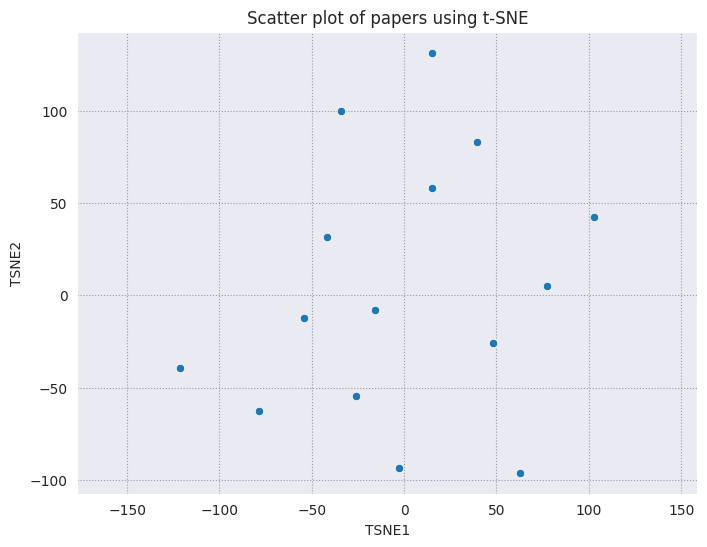

In [69]:
fig, ax = plt.subplots(figsize=(8,6)) # Set figsize
sns.set_style('darkgrid', {"grid.color": ".6", "grid.linestyle": ":"})
sns.scatterplot(data=df_tsne, x='TSNE1', y='TSNE2')
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title('Scatter plot of papers using t-SNE');
plt.xlabel('TSNE1');
plt.ylabel('TSNE2');
plt.axis('equal')

In [70]:
kmeans_model = KMeans(n_clusters=7, random_state=0, n_init="auto").fit(X)
labels = kmeans_model.fit_predict(X)
df_tsne['Cluster'] = labels
df_tsne

,TSNE1,TSNE2,Cluster
0,39.483353,83.195900,4
1,-54.273861,-12.529912,5
2,-15.640708,-8.172785,5
3,48.192043,-25.647438,1
4,-2.934726,-93.651268,0
5,62.591106,-96.062981,2
6,-34.267071,99.978371,4
7,14.996202,57.953194,4
8,-26.215324,-54.779854,0
9,103.053604,42.461842,1


(np.float64(-132.51340560913087),
 np.float64(114.2710807800293),
 np.float64(-107.43205909729004),
 np.float64(142.68766670227052))

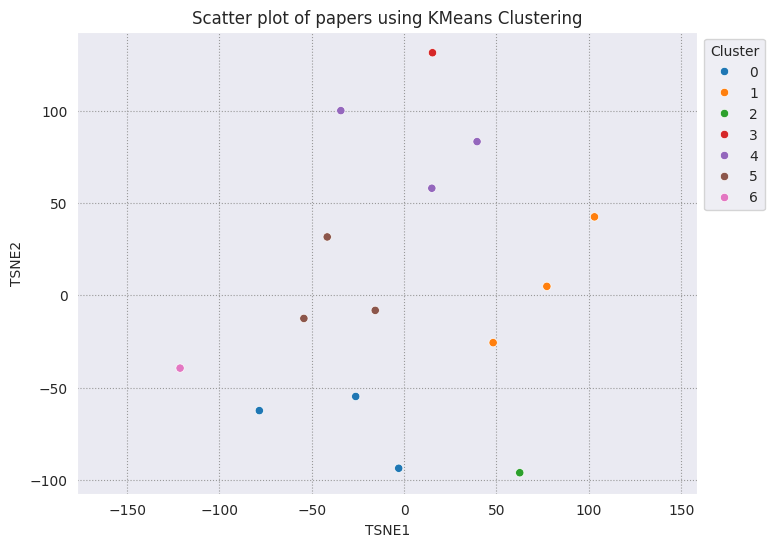

In [71]:
fig, ax = plt.subplots(figsize=(8,6)) # Set figsize
sns.set_style('darkgrid', {"grid.color": ".6", "grid.linestyle": ":"})
sns.scatterplot(data=df_tsne, x='TSNE1', y='TSNE2', hue='Cluster', palette='tab10')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title('Scatter plot of papers using KMeans Clustering');
plt.xlabel('TSNE1');
plt.ylabel('TSNE2');
plt.axis('equal')

In [75]:
class Cluster(TypedDict):
    name: str
    details: str
    papers: list[str]


cluster_prompt = f"""
Instructions:
- Identify appropriate clusters from the below papers provided as JSON data. Each cluster should identify a general technique/approach used within the domain.
- The JSON data is in the following format:
  {{"paperId": {{"title": str, "abstract": str, "pdf_url": str}}}}
- Minimum clusters should be 3
- Cluster the papers into each of the identified clusters
- Provide an explaination for each cluster as the "details" of that cluster

Input:
{json.dumps(papers)}
```
"""

gen_config = {"response_mime_type": "application/json", "response_schema": list[Cluster]}

response = model.generate_content(cluster_prompt, generation_config=gen_config)

clusters = json.loads(response.text)

pprint(clusters)

[{'details': 'This cluster focuses on image retrieval techniques that utilize '
             'deep learning models for feature extraction. These papers '
             'leverage pre-trained convolutional neural networks (CNNs) like '
             'ResNet, VGG, and Inception to extract high-level features from '
             'images. These features are then used for classification or '
             'similarity matching to retrieve relevant images.',
  'name': 'Deep Learning-Based Image Retrieval',
  'papers': ['969616fc1b82807ee7fb0f7f03f60972e8e6f6c3',
             '7e2689f1c14509cef2455171adb13e2412aebd3e',
             '5dac2f75c67c7be80ea666a4b6c86953c9990b63']},
 {'details': 'This cluster focuses on using graph neural networks (GNNs) for '
             'few-shot image classification. The papers in this cluster '
             'explore how to improve the performance of GNNs in this '
             'challenging setting, often by incorporating hierarchical node '
             'residual c

In [77]:
prompt = f"""
For each of the clusters in the below input, provide a concise summary of the cluster. Additionally, compare how each cluster is similar or different from the others.
Perform an in-depth comparison between these techniques.

Input:
{json.dumps(list(map(lambda x: x["name"], clusters)))}
```
"""

response = model.generate_content(prompt)

print(response.text)

## Cluster Summaries and Comparisons:

**Cluster 1: Image Classification and Retrieval using Deep Learning**

* **Papers:** "Deep Learning-Based Image Retrieval", "Graph Neural Networks for Few-Shot Image Classification", "Image Classification with Limited Labeled Data", "Medical Image Classification and Retrieval", "Clothing Genre Recognition using Image Processing", "Enhanced Semantic Image Retrieval using Hybrid Approaches" 

* **Summary:** This cluster focuses on various aspects of image classification and retrieval using deep learning techniques. It covers methods for dealing with limited data, leveraging graph neural networks for few-shot learning, and improving retrieval performance with hybrid approaches that combine semantic and visual information. 

**Cluster 2: Knowledge Graphs and their Usages**

* **Papers:** "Knowledge Graphs and Their Usages"

* **Summary:** This cluster focuses on knowledge graphs, exploring their construction, usage, and applications in various domains

In [ ]:
class Subproblem(TypedDict):
    prompt: str
    requires_internet: bool
    requires_previous_output: bool


prompt = f"""
You are researching the below topic and need to write a survey paper on the same. Your current goal is only to research on the topic 
and not write anything currently.

Topic: {topic}

Instructions:
- Identify the key areas of focus within this topic and outline the subproblems that need to be addressed
- For each subproblem, create a concise prompt that states the task to be performed
- Indicate whether internet access is necessary to complete the subproblem. Assume that around 15-20 relevant research papers will be provided to you.
- Determine if the output of the previous subproblem is relevant to the subsequent subproblem
- Your first subproblem should always be a query string that can be used to find relevant research papers from the Semantic Scholar database

Do not generate the same instructions as your output. Ensure that you provide relevant subproblems that can be addressed by you.
Ensure that your output is in the correct format since it will be parsed automatically.
"""

gen_config = {"response_mime_type": "application/json", "response_schema": list[Subproblem]}

response = model.generate_content(prompt, generation_config=gen_config)

In [36]:
subproblems = json.loads(response.text)
year = date.today().year
results = search_semantic_scholar(subproblems[0]["prompt"], (year - 10, year))

for item in results:
    print(item)

{'paperId': 'f55c3d53eaacc75f497a55ab349276b18ea98cc1', 'title': 'Fused Node-Level Residual Structure Edge Graph Neural Network for Few-Shot Image Classification', 'abstract': 'In spite of recent rapid developments across various computer vision domains, numerous cutting-edge deep learning algorithms often demand a substantial volume of data to operate effectively. Within this research, a novel few-shot learning approach is presented with the objective of enhancing the accuracy of few-shot image classification. This task entails the classification of unlabeled query samples based on a limited set of labeled support examples. Specifically, the integration of the edge-conditioned graph neural network (EGNN) framework with hierarchical node residual connections is proposed. The primary aim is to enhance the performance of graph neural networks when applied to few-shot classification, a rather unconventional application of hierarchical node residual structures in few-shot image classificat

KeyboardInterrupt: 

In [20]:
internet_prompt_template = """
{prompt}
- Based on the above details, create a relevant and concise search query to be used on Semantic Scholar
- Search the Semantic Scholar database for your query
- Determine the relevance (as percentage) of the returned papers based on the title, abstract, and tldr of each search result

{extra_context}
"""
sub_prompt_template = """
{prompt}

{extra_context}
"""

outputs = [None] * len(subproblems)
for i, subproblem in enumerate(subproblems):
    pprint(subproblem, width=120, indent=2)

    if subproblem["requires_internet"]:
        sub_prompt = internet_prompt_template.format(
            prompt=subproblem["prompt"],
            extra_context="" if not subproblem["requires_previous_output"] else f"Extra Context:\n{outputs[i - 1]}",
        )
    else:
        sub_prompt = sub_prompt_template.format(
            prompt=subproblem["prompt"],
            extra_context="" if not subproblem["requires_previous_output"] else f"Extra Context:\n{outputs[i - 1]}",
        )
    outputs[i] = model.generate_content(sub_prompt).text

{'prompt': 'Identify and categorize different TCP congestion control '
           'algorithms based on their underlying mechanisms and principles '
           '(e.g., slow start, congestion avoidance, fast retransmit, fast '
           'recovery).',
 'requires_internet': True,
 'requires_previous_output': False}
{'prompt': 'Analyze the strengths and weaknesses of each algorithm in terms of '
           'network performance metrics such as throughput, delay, fairness, '
           'and robustness to network conditions.',
 'requires_internet': True,
 'requires_previous_output': True}
{'prompt': 'Compare and contrast the performance of different algorithms under '
           'varying network conditions (e.g., bandwidth variations, packet '
           'losses, buffer sizes) using simulations or real-world experiments.',
 'requires_internet': True,
 'requires_previous_output': True}
{'prompt': 'Investigate the impact of emerging technologies such as 5G and '
           'edge computing on TC

In [21]:
for output in outputs:
    print(output)

```json
{
  "query": "tcp congestion control algorithms",
  "fields": ["title", "abstract", "venue", "authors", "year", "citations"],
  "citationContext": true,
  "limit": 100,
  "include_paper_id": true,
  "sort": {
    "citations": "desc"
  },
  "filter": {
    "publication_date": {
      "from": 2010,
      "to": 2023
    }
  }
}
```

**Explanation:**

* **`query`:** This sets the main search term as "tcp congestion control algorithms". 
* **`fields`:** This specifies the data fields to be retrieved for each paper, including title, abstract, venue, authors, publication year, citation count, and the paper ID.
* **`citationContext`:** This flag enables retrieving the citation context, providing insights into how the paper is referenced in other works.
* **`limit`:** This limits the search results to the top 100 most cited papers.
* **`include_paper_id`:** This ensures the paper ID is included in the response, which is useful for further analysis.
* **`sort`:** This sorts the results b